# Part B: Text classification

The dataset used in this project contains the first paragraphs collected from Wikipage entries and the corresponding labels about their category. You will implement CNN and RNN layers at the word and character levels for the classification of texts in the paragraphs. The output layer of the networks is a softmax layer.

In [1]:
# import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
# import nltk
import tensorflow as tf

In [36]:
# download tokenizer
# nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
print(tf.__version__)

2.3.0


In [3]:
# make sure Google Colaboratory is using GPU instance
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# set seed for replication
# random shuffling while fitting
seed = 0
tf.random.set_seed(seed)

The training and test datasets will be read from **'train_medium.csv'** and **'test_medium.csv'** files. The training dataset contains 5600 entries and test dataset contains 700 entries. The label of an entry is one of the 15 categories such as people, company, schools, etc.

In [5]:
num_categories = 15

In [6]:
# files uploaded to Google Colaboratory
train_data_path = '/content/CZ4042_assignment2/train_medium.csv'
test_data_path = '/content/CZ4042_assignment2/test_medium.csv'

In [7]:
# take a look at the data
with open(train_data_path) as data_file:
    for index, line in enumerate(data_file):
        # first 5 lines is enough
        if index >= 5:
            break

        print(line)

7, Park Dinor is a historic diner located at Lawrence Park Township Erie County Pennsylvania. It was built in 1948 by the Paterson Vehicle Co. of Paterson New Jersey. It is a one-story pre-fabricated stainless steel and porcelain building. The diner measures 40 feet long by 14 feet wide and has an attached concrete block kitchen measuring 13 feet by 11 feet six inches. Also on the property is a contributing pre-fabricated 384 square foot cottage also erected in 1948.,,,,,,,

9, Betan is a village development committee in Surkhet District in the Bheri Zone of mid-western Nepal. At the time of the 1991 Nepal census it had a population of 2644 people living in 407 individual households.,,,,,,,

4, Christopher Benjamin Rungkat (born 14 January 1990) is an Indonesian tennis player. He is the grandson of Famous Benny Rungkat former chairman of the Indonesian Air Carriers Association. Christopher's father Michael Alexander Fritz Rungkat is of Dutch and Indonesian descent and his mother Elfia 

In [8]:
def extract_data_from_text(data_file_path: str):
    features, labels = [], []
    with open(data_file_path) as data_file:
        
        for line in data_file:
            line = line.replace(',,,,,,,\n', '')
            category, entry = tuple(line.split(', ', maxsplit=1))
            
            features.append(entry)
            labels.append(int(category))

    return features, labels

In [9]:
raw_train_features, raw_train_labels = extract_data_from_text(train_data_path)

print(len(raw_train_features))

# actual number of categories does not affect results
print(sorted(set(raw_train_labels)))

5600
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


In [10]:
raw_test_features, raw_test_labels = extract_data_from_text(test_data_path)

print(len(raw_test_features))

# actual number of categories does not affect results
print(sorted(set(raw_test_labels)))

700
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


The input data is in text, which should be converted to character/word IDs to feed to the networks (Please refer to our given two smaple codes (CNN and RNN) which process text data in terms of character and word respectively). Restrict the maximum length of the characters/word inputs to **100** and the maximum number of training epoch to **250**. Use the **Adam or SGD optimizers** for training with a **batch size = 128** and **learning rate = 0.01**. Assume there are **256** different characters.

In [47]:
max_input_length = 100
num_epochs = 250
batch_size = 128
learning_rate = 0.01
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
num_characters = 256

# additional params
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

# 1. 

Design a Character CNN Classifier that receives character ids and classifies the input. The CNN has two convolution and pooling layers:

- A convolution layer $C_1$ of 10 filters of window size 20x256, VALID padding, and ReLU neurons. A max pooling layer $S_1$ with a pooling window of size 4x4, with stride = 2, and padding = 'SAME'.
- A convolution layer $C_2$ of 10 filters of window size 20x1, VALID padding, and ReLU neurons. A max pooling layer $S_2$ with a pooling window of size 4x4, with stride = 2 and padding = 'SAME'.

Plot the entropy cost on the training data and the accuracy on the testing data against
training epochs.

In [53]:
# reference: sample code's vocabulary()
def get_char_id_map(strings: list) -> dict:
    '''
    Gives a mapping of each character to its corresponding id.

    :params:
    - strings (list): a list of strings

    :return:
    - a map of characters to their corresponding ids (dict)
    '''
    characters = sorted(set(''.join(strings).lower()))
    char_id_map = {char: id for id, char in enumerate(characters)}
    
    return char_id_map

In [54]:
# reference: sample code's preprocess()
def convert_char_to_id(strings: list, char_id_map: dict) -> np.ndarray:
    '''
    encode as 2d array:
    number of rows -> number of entries
    number of columns -> entry length (normalised to max_input_length)
    '''
    char_encodings = []

    for string in strings:
        string = string.lower()
        if len(string) > max_input_length:  # too long -> truncate
            string = string[:max_input_length]
        
        elif len(string) < max_input_length:  # too short -> pad white space
            string += ' ' * (max_input_length - len(string))

        char_encodings.append([char_id_map[char] for char in string])

    return np.array(char_encodings)

In [56]:
# reference: sample code
def convert_one_hot(features):
    one_hot_features = tf.one_hot(features, num_characters)
    one_hot_features = tf.expand_dims(one_hot_features, axis=-1)

    return one_hot_features

In [64]:
# preprocess data by encoding them and normalising length
char_id_map = get_char_id_map(raw_train_features + raw_test_features)

train_features = convert_char_to_id(raw_train_features, char_id_map)
train_labels = np.array(raw_train_labels)

test_features = convert_char_to_id(raw_test_features, char_id_map)
test_labels = np.array(raw_test_labels)

# use one-hot encoding
train_features = convert_one_hot(train_features)
test_features = convert_one_hot(test_features)

# print out data info
vocab_size = len(char_id_map.keys())
print(f'vocabulary size: {vocab_size}')

print(f'train features shape: {train_features.shape}')
print(f'train labels shape: {train_labels.shape}')

print(f'test features shape: {test_features.shape}')
print(f'test labels shape: {test_labels.shape}')

vocabulary size: 1173
train features shape: (5600, 100, 256, 1)
train labels shape: (5600,)
test features shape: (700, 100, 256, 1)
test labels shape: (700,)


In [59]:
def get_character_cnn() -> tf.keras.models.Sequential:
    input_layer = tf.keras.layers.Input(
        shape=(max_input_length, num_characters, 1),
    )

    c1 = tf.keras.layers.Conv2D(
        filters=10,
        kernel_size=(20, 256),
        padding='valid',
        activation='relu',
    )

    s1 = tf.keras.layers.MaxPool2D(
        pool_size=(4, 4),
        strides=2,
        padding='same',
    )

    c2 = tf.keras.layers.Conv2D(
        filters=10,
        kernel_size=(20, 1),
        padding='valid',
        activation='relu',
    )

    s2 = tf.keras.layers.MaxPool2D(
        pool_size=(4, 4),
        strides=2,
        padding='same',
    )

    flatten = tf.keras.layers.Flatten()

    fully_connected = tf.keras.layers.Dense(
        units=num_categories,
        activation='softmax',
    )

    return tf.keras.models.Sequential([
        input_layer,
        c1,
        s1,
        c2,
        s2,
        flatten,
        fully_connected,
    ])

In [60]:
model = get_character_cnn()
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics,
)

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 81, 1, 10)         51210     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 41, 1, 10)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 1, 10)         2010      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 1, 10)         0         
_________________________________________________________________
flatten (Flatten)            (None, 110)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 15)                1665      
Total params: 54,885
Trainable params: 54,885
Non-trainable params: 0
__________________________________________________

In [61]:
%%time
history = model.fit(
    x=train_features,
    y=train_labels,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(test_features, test_labels),
)

Epoch 1/250
44/44 [==============================] - 1s 15ms/step - loss: 2.6111 - accuracy: 0.1811 - val_loss: 2.5400 - val_accuracy: 0.2671
Epoch 2/250
44/44 [==============================] - 0s 10ms/step - loss: 2.5075 - accuracy: 0.3002 - val_loss: 2.4843 - val_accuracy: 0.3314
Epoch 3/250
44/44 [==============================] - 0s 10ms/step - loss: 2.4568 - accuracy: 0.3562 - val_loss: 2.4529 - val_accuracy: 0.3600
Epoch 4/250
44/44 [==============================] - 0s 10ms/step - loss: 2.4422 - accuracy: 0.3725 - val_loss: 2.4755 - val_accuracy: 0.3343
Epoch 5/250
44/44 [==============================] - 0s 10ms/step - loss: 2.4203 - accuracy: 0.3946 - val_loss: 2.4493 - val_accuracy: 0.3600
Epoch 6/250
44/44 [==============================] - 0s 10ms/step - loss: 2.3933 - accuracy: 0.4223 - val_loss: 2.4237 - val_accuracy: 0.3886
Epoch 7/250
44/44 [==============================] - 0s 10ms/step - loss: 2.4078 - accuracy: 0.4077 - val_loss: 2.4537 - val_accuracy: 0.3600
Epoch 

In [51]:
# define function to plot loss and accuracy curves for usage later
def plot_loss_accuracy_curves(num_epochs: int, history: dict):
    '''
    Plots loss curve and accuracy curve side-by-side.
    
    :params:
    - total_num_epochs (int): total number of epochs for model to get minimal test error
    - history (dict): history of loss and accuracy values at each epoch
        - keys: 'loss', 'val_loss', 'accuracy', 'val_accuracy'
    '''
    _, (loss_axis, accuracy_axis) = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))

    loss_axis.set_title('loss')
    loss_axis.plot(range(num_epochs), history['loss'], label='train')
    loss_axis.plot(range(num_epochs), history['val_loss'], label='test')
    loss_axis.legend()

    accuracy_axis.set_title('accuracy')
    accuracy_axis.plot(range(num_epochs), history['accuracy'], label='train')
    accuracy_axis.plot(range(num_epochs), history['val_accuracy'], label='test')
    accuracy_axis.legend()

highest validation accuracy achieved: 0.5042856931686401


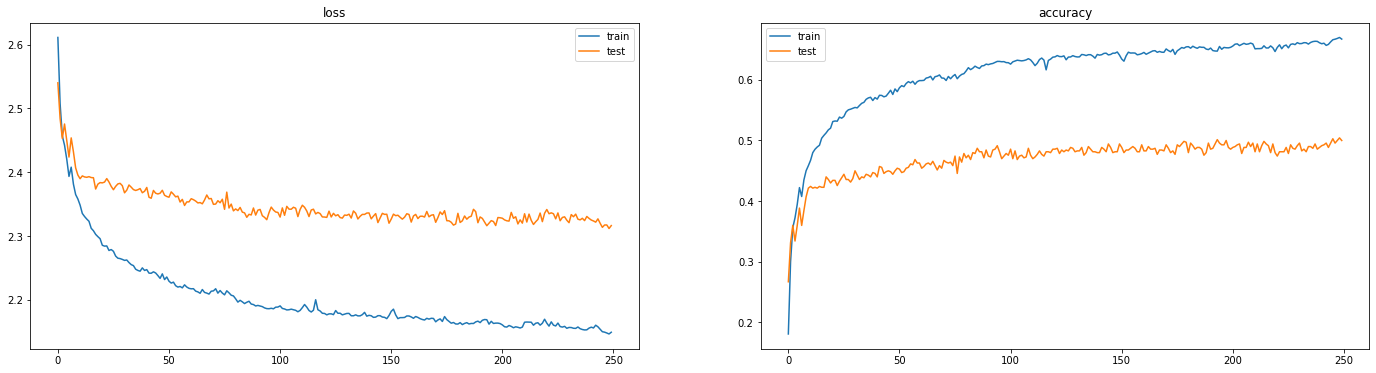

In [62]:
# Plot the entropy cost on the training data and 
# the accuracy on the testing data against training epochs.
plot_loss_accuracy_curves(num_epochs, history.history)

val_accuracies = history.history['val_accuracy']
print(f'highest validation accuracy achieved: {max(val_accuracies)}')

# 2. 

Design a Word CNN Classifier that receives word ids and classifies the input. Pass the inputs through an embedding layer of size 20 before feeding to the CNN. The CNN has two convolution and pooling layers with the following characteristics:

- A convolution layer $C_1$ of 10 filters of window size 20x20, VALID padding, and ReLU neurons. A max pooling layer $S_1$ with a pooling window of size 4x4, with stride = 2 and padding = 'SAME'.
- A convolution layer $C_2$ of 10 filters of window size 20x1, , VALID padding, and ReLU neurons. A max pooling layer $S_2$ with a pooling window of size 4x4, with stride = 2 and padding = 'SAME'.

Plot the entropy cost on training data and the accuracy on testing data against training epochs.

In [99]:
# try out Tensorflow's tokenizer
words = tf.keras.preprocessing.text.text_to_word_sequence(raw_train_features[0])
print(words)

['park', 'dinor', 'is', 'a', 'historic', 'diner', 'located', 'at', 'lawrence', 'park', 'township', 'erie', 'county', 'pennsylvania', 'it', 'was', 'built', 'in', '1948', 'by', 'the', 'paterson', 'vehicle', 'co', 'of', 'paterson', 'new', 'jersey', 'it', 'is', 'a', 'one', 'story', 'pre', 'fabricated', 'stainless', 'steel', 'and', 'porcelain', 'building', 'the', 'diner', 'measures', '40', 'feet', 'long', 'by', '14', 'feet', 'wide', 'and', 'has', 'an', 'attached', 'concrete', 'block', 'kitchen', 'measuring', '13', 'feet', 'by', '11', 'feet', 'six', 'inches', 'also', 'on', 'the', 'property', 'is', 'a', 'contributing', 'pre', 'fabricated', '384', 'square', 'foot', 'cottage', 'also', 'erected', 'in', '1948']


In [149]:
# reference: sample code's build_word_dict()
def get_word_id_map(strings: list) -> dict:
    '''
    Gives a mapping of each word to its corresponding id.

    :params:
    - strings (list): a list of strings

    :return:
    - a map of words to their corresponding ids (dict)
    '''
    # <pad> -> to pad entry length if it is too short
    # <unk> -> id for any words that are unknown
    word_set = set(['<pad>', '<unk>', '<eos>'])

    for string in strings:
        words = tf.keras.preprocessing.text.text_to_word_sequence(string)
        word_set.union(words)
    
    word_id_map = {word: id for id, word in enumerate(word_set)}

    return word_id_map

In [150]:
# reference: sample code's preprocess()
def convert_word_to_id(strings: list, word_id_map: dict) -> np.ndarray:
    '''
    encode as 2d array:
    number of rows -> number of entries
    number of columns -> entry length (normalised to max_input_length)
    '''
    word_encodings = []

    for string in strings:
        words = tf.keras.preprocessing.text.text_to_word_sequence(string)
        words += ['<eos>']

        if len(words) > max_input_length:  # too long -> truncate
            words = words[:max_input_length]
        
        elif len(words) < max_input_length:  # too short -> pad white space
            words += ['<pad>'] * (max_input_length - len(words))

        word_encodings.append([
            word_id_map.get(word, word_id_map['<unk>'])
            for word in words
        ])

    return np.array(word_encodings)

In [151]:
# preprocess data by encoding them and normalising length
word_id_map = get_word_id_map(raw_train_features + raw_test_features)

train_features = convert_word_to_id(raw_train_features, word_id_map)
one_hot_train = convert_one_hot(train_features)
train_labels = np.array(raw_train_labels)

test_features = convert_word_to_id(raw_test_features, word_id_map)
one_hot_test = convert_one_hot(test_features)
test_labels = np.array(raw_test_labels)

vocab_size = len(char_id_map.keys())
print(f'vocabulary size: {vocab_size}')

print(f'train features shape: {one_hot_train.shape}')
print(f'train labels shape: {train_labels.shape}')

print(f'test features shape: {test_features.shape}')
print(f'test labels shape: {one_hot_test.shape}')

vocabulary size: 1173
train features shape: (5600, 100, 256, 1)
train labels shape: (5600,)
test features shape: (700, 100)
test labels shape: (700, 100, 256, 1)


In [152]:
def get_word_cnn() -> tf.keras.models.Sequential:
    model = tf.keras.models.Sequential()

    embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=20,  # embedding size
        input_length=max_input_length,
    )
    model.add(embedding)

    expand_dims = tf.keras.layers.Lambda(
        lambda x: tf.expand_dims(x, axis=-1),
    )
    model.add(expand_dims)

    c1 = tf.keras.layers.Conv2D(
        filters=10,
        kernel_size=(20, 20),
        padding='valid',
        activation='relu',
    )
    model.add(c1)

    s1 = tf.keras.layers.MaxPool2D(
        pool_size=(4, 4),
        strides=2,
        padding='same',
    )
    model.add(s1)

    dropout1 = tf.keras.layers.Dropout(rate=0.5)
    model.add(dropout1)

    c2 = tf.keras.layers.Conv2D(
        filters=10,
        kernel_size=(20, 1),
        padding='valid',
        activation='relu',
    )
    model.add(c2)

    s2 = tf.keras.layers.MaxPool2D(
        pool_size=(4, 4),
        strides=2,
        padding='same',
    )
    model.add(s2)

    dropout2 = tf.keras.layers.Dropout(rate=0.5)
    model.add(dropout2)

    flatten = tf.keras.layers.Flatten()
    model.add(flatten)

    fully_connected = tf.keras.layers.Dense(
        units=num_categories,
        activation='softmax',
    )
    model.add(fully_connected)

    return model

In [153]:
model = get_word_cnn()
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics,
)

model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 100, 20)           23460     
_________________________________________________________________
lambda_14 (Lambda)           (None, 100, 20, 1)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 81, 1, 10)         4010      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 41, 1, 10)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 41, 1, 10)         0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 22, 1, 10)         2010      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 11, 1, 10)       

In [154]:
%%time
history = model.fit(
    x=train_features,
    y=train_labels,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(test_features, test_labels),
)

Epoch 1/250
44/44 [==============================] - 0s 7ms/step - loss: 2.7368 - accuracy: 0.0739 - val_loss: 2.7451 - val_accuracy: 0.0714
Epoch 2/250
44/44 [==============================] - 0s 5ms/step - loss: 2.7440 - accuracy: 0.0725 - val_loss: 2.7451 - val_accuracy: 0.0714
Epoch 3/250
44/44 [==============================] - 0s 4ms/step - loss: 2.7456 - accuracy: 0.0707 - val_loss: 2.7451 - val_accuracy: 0.0714
Epoch 4/250
44/44 [==============================] - 0s 5ms/step - loss: 2.7446 - accuracy: 0.0720 - val_loss: 2.7451 - val_accuracy: 0.0714
Epoch 5/250
44/44 [==============================] - 0s 5ms/step - loss: 2.7453 - accuracy: 0.0711 - val_loss: 2.7451 - val_accuracy: 0.0714
Epoch 6/250
44/44 [==============================] - 0s 5ms/step - loss: 2.7453 - accuracy: 0.0712 - val_loss: 2.7451 - val_accuracy: 0.0714
Epoch 7/250
44/44 [==============================] - 0s 5ms/step - loss: 2.7452 - accuracy: 0.0712 - val_loss: 2.7451 - val_accuracy: 0.0714
Epoch 8/250
4

highest validation accuracy achieved: 0.0771428570151329


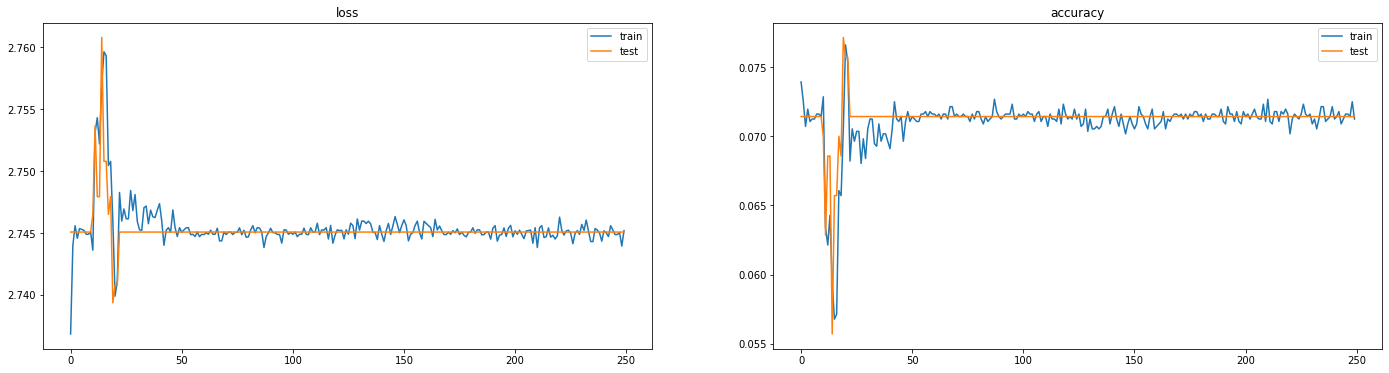

In [155]:
# Plot the entropy cost on the training data and 
# the accuracy on the testing data against training epochs.
plot_loss_accuracy_curves(num_epochs, history.history)

val_accuracies = history.history['val_accuracy']
print(f'highest validation accuracy achieved: {max(val_accuracies)}')

# 3. 

Design a Character RNN Classifier that receives character ids and classify the input. The RNN is GRU layer and has a hidden-layer size of 20.


Plot the entropy cost on training data and the accuracy on testing data against training epochs.

In [156]:
# preprocess data by encoding them and normalising length
char_id_map = get_char_id_map(raw_train_features + raw_test_features)

train_features = convert_char_to_id(raw_train_features, char_id_map)
train_labels = np.array(raw_train_labels)

test_features = convert_char_to_id(raw_test_features, char_id_map)
test_labels = np.array(raw_test_labels)

# use one-hot encoding
train_features = tf.one_hot(train_features, num_characters)
test_features = tf.one_hot(test_features, num_characters)

# print out data info
vocab_size = len(char_id_map.keys())
print(f'vocabulary size: {vocab_size}')

print(f'train features shape: {train_features.shape}')
print(f'train labels shape: {train_labels.shape}')

print(f'test features shape: {test_features.shape}')
print(f'test labels shape: {test_labels.shape}')

vocabulary size: 1173
train features shape: (5600, 100, 256)
train labels shape: (5600,)
test features shape: (700, 100, 256)
test labels shape: (700,)


In [171]:
# design character RNN classifier
def get_character_rnn(
    rnn_type: str = 'gru',
    num_rnn_layers: int = 1,
    use_dropout: bool = False,
) -> tf.keras.Sequential:
    '''
    Generates a character RNN classifier.

    :params:
    - rnn_type (str): type of rnn - 'gru', 'vanilla' or 'lstm' (default: 'gru)
    - num_rnn_layers (int): number of RNN layers (default: 1)
    - use_dropout (bool): whether to use dropout rate of 0.5 (default: False)

    :return:
    - an initial model (tf.keras.Sequential)
    '''    
    if rnn_type not in ('gru', 'vanilla', 'lstm'):
        raise ValueError('invalid RNN type')
    
    if num_rnn_layers < 1:
        raise ValueError('invalid number of RNN layers')

    model = tf.keras.Sequential()

    input_layer = tf.keras.layers.Input(
        shape=(max_input_length, num_characters),
    )
    model.add(input_layer)

    if rnn_type == 'gru':
        for _ in range(num_rnn_layers):
            gru = tf.keras.layers.GRU(
                units=20,
                dropout=0.5 if use_dropout else 0,
            )
            model.add(gru)
    elif rnn_type == 'vanilla':
        for _ in range(num_rnn_layers):
            rnn = tf.keras.layers.SimpleRNN(
                units=20,
                dropout=0.5 if use_dropout else 0,
            )
            model.add(rnn)
    elif rnn_type == 'lstm':
        for _ in range(num_rnn_layers):
            lstm = tf.keras.layers.LSTM(
                units=20,
                dropout=0.5 if use_dropout else 0,
            )
            model.add(lstm)

    fully_connected = tf.keras.layers.Dense(
        units=num_categories,
        # activation='softmax',
    )
    model.add(fully_connected)

    return model

In [172]:
model = get_character_rnn()
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics,
)

model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_18 (GRU)                 (None, 20)                16680     
_________________________________________________________________
dense_30 (Dense)             (None, 15)                315       
Total params: 16,995
Trainable params: 16,995
Non-trainable params: 0
_________________________________________________________________


In [173]:
%%time
history = model.fit(
    x=train_features,
    y=train_labels,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(test_features, test_labels),
)

Epoch 1/250
44/44 [==============================] - 1s 20ms/step - loss: 2.5742 - accuracy: 0.1248 - val_loss: 2.2466 - val_accuracy: 0.2314
Epoch 2/250
44/44 [==============================] - 1s 13ms/step - loss: 1.7236 - accuracy: 0.4209 - val_loss: 1.4771 - val_accuracy: 0.4929
Epoch 3/250
44/44 [==============================] - 1s 13ms/step - loss: 1.2409 - accuracy: 0.5763 - val_loss: 1.2718 - val_accuracy: 0.5529
Epoch 4/250
44/44 [==============================] - 1s 13ms/step - loss: 1.0401 - accuracy: 0.6489 - val_loss: 1.1743 - val_accuracy: 0.6200
Epoch 5/250
44/44 [==============================] - 1s 13ms/step - loss: 0.8995 - accuracy: 0.7050 - val_loss: 1.0872 - val_accuracy: 0.6429
Epoch 6/250
44/44 [==============================] - 1s 14ms/step - loss: 0.7933 - accuracy: 0.7434 - val_loss: 1.0745 - val_accuracy: 0.6629
Epoch 7/250
44/44 [==============================] - 1s 13ms/step - loss: 0.7248 - accuracy: 0.7646 - val_loss: 1.0336 - val_accuracy: 0.6529
Epoch 

highest validation accuracy achieved: 0.7285714149475098


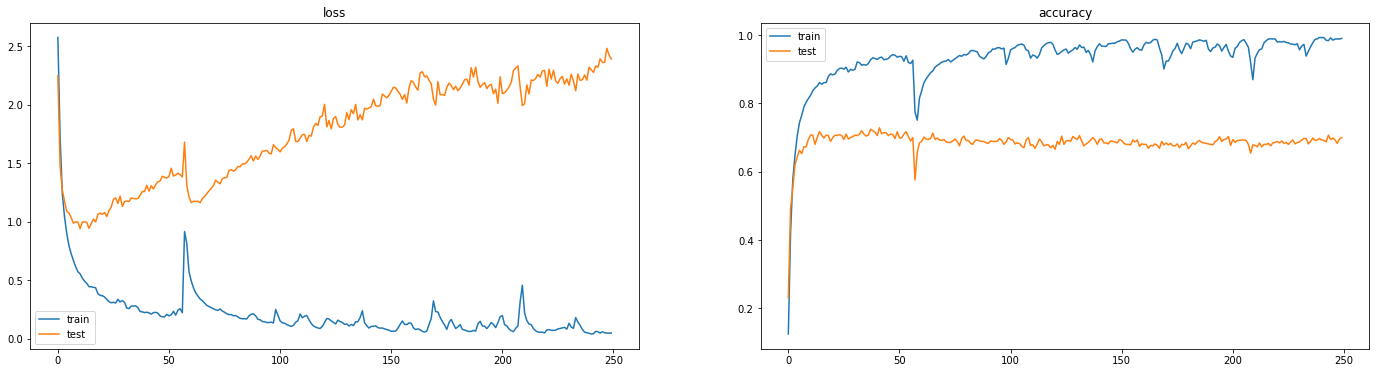

In [174]:
# Plot the entropy cost on the training data and 
# the accuracy on the testing data against training epochs.
plot_loss_accuracy_curves(num_epochs, history.history)

val_accuracies = history.history['val_accuracy']
print(f'highest validation accuracy achieved: {max(val_accuracies)}')

# 4. 

Design a word RNN classifier that receives word ids and classify the input. The RNN is GRU layer and has a hidden-layer size of 20. Pass the inputs through an embedding layer of size 20 before feeding to the RNN.


Plot the entropy on training data and the accuracy on testing data versus training epochs.

In [31]:
# params
embedding_size = 20

In [114]:
# prepare data
raw_train_ds = tf.data.Dataset.from_tensor_slices((
    raw_train_features,
    raw_train_labels,
)).batch(batch_size)

raw_test_ds = tf.data.Dataset.from_tensor_slices((
    raw_test_features,
    raw_test_labels,
)).batch(batch_size)

# confirm that dataset is ok
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print(text_batch.numpy()[i])
        print(label_batch.numpy()[i])

# reference: https://www.tensorflow.org/tutorials/keras/text_classification
# reference: https://www.tensorflow.org/tutorials/text/text_classification_rnn
vectorize_layer = tf.keras.layers.experimental.preprocessing.TextVectorization(
    output_sequence_length=max_input_length,
)

vectorize_layer.adapt(raw_train_features + raw_test_features)

# need vocab size for RNN design later
vocab_size = len(vectorize_layer.get_vocabulary())
print(f'vocabulary size: {vocab_size}')


def vectorize(features, labels):
    features = tf.expand_dims(features, axis=-1)
    return vectorize_layer(features), labels


# confirm that vectorization works
train_features, train_labels = vectorize(raw_train_features, raw_train_labels)
print(train_features.shape)

test_features, test_labels = vectorize(raw_test_features, raw_test_labels)
print(test_features.shape)

print(train_features[0])

train_ds = raw_train_ds.map(vectorize)
test_ds = raw_test_ds.map(vectorize)

train_ds = train_ds.cache()
test_ds = test_ds.cache()

b'Park Dinor is a historic diner located at Lawrence Park Township Erie County Pennsylvania. It was built in 1948 by the Paterson Vehicle Co. of Paterson New Jersey. It is a one-story pre-fabricated stainless steel and porcelain building. The diner measures 40 feet long by 14 feet wide and has an attached concrete block kitchen measuring 13 feet by 11 feet six inches. Also on the property is a contributing pre-fabricated 384 square foot cottage also erected in 1948.'
7
b'Betan is a village development committee in Surkhet District in the Bheri Zone of mid-western Nepal. At the time of the 1991 Nepal census it had a population of 2644 people living in 407 individual households.'
9
b"Christopher Benjamin Rungkat (born 14 January 1990) is an Indonesian tennis player. He is the grandson of Famous Benny Rungkat former chairman of the Indonesian Air Carriers Association. Christopher's father Michael Alexander Fritz Rungkat is of Dutch and Indonesian descent and his mother Elfia Mirlianti is 

In [45]:
# design word RNN classifier
def get_word_rnn(
    rnn_type: str = 'gru',
    num_rnn_layers: int = 1,
    use_dropout: bool = False,
) -> tf.keras.Sequential:
    '''
    Generates a word RNN classifier.

    :params:
    - rnn_type (str): type of rnn - 'gru', 'vanilla' or 'lstm' (default: 'gru)
    - num_rnn_layers (int): number of RNN layers (default: 1)
    - use_dropout (bool): whether to use dropout rate of 0.5 (default: False)

    :return:
    - an initial model (tf.keras.Sequential)
    '''    
    if rnn_type not in ('gru', 'vanilla', 'lstm'):
        raise ValueError('invalid RNN type')
    
    if num_rnn_layers < 1:
        raise ValueError('invalid number of RNN layers')

    model = tf.keras.Sequential()

    embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_size,
        input_length=max_input_length,
    )
    model.add(embedding)

    if rnn_type == 'gru':
        for _ in range(num_rnn_layers):
            gru = tf.keras.layers.GRU(
                units=20,
                dropout=0.5 if use_dropout else 0,
            )
            model.add(gru)
    elif rnn_type == 'vanilla':
        for _ in range(num_rnn_layers):
            rnn = tf.keras.layers.SimpleRNN(
                units=20,
                dropout=0.5 if use_dropout else 0,
            )
            model.add(rnn)
    elif rnn_type == 'lstm':
        for _ in range(num_rnn_layers):
            lstm = tf.keras.layers.LSTM(
                units=20,
                dropout=0.5 if use_dropout else 0,
            )
            model.add(lstm)

    fully_connected = tf.keras.layers.Dense(
        units=num_categories,
    )
    model.add(fully_connected)

    return model

In [48]:
# get the model
model = get_word_rnn()
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics,
)

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 20)           792040    
_________________________________________________________________
gru_6 (GRU)                  (None, 20)                2520      
_________________________________________________________________
dense_6 (Dense)              (None, 15)                315       
Total params: 794,875
Trainable params: 794,875
Non-trainable params: 0
_________________________________________________________________


In [49]:
%%time
history = model.fit(
    train_ds,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=test_ds,
)

Epoch 1/250
44/44 [==============================] - 1s 24ms/step - loss: 2.6639 - accuracy: 0.0654 - val_loss: 2.6457 - val_accuracy: 0.0714
Epoch 2/250
44/44 [==============================] - 1s 13ms/step - loss: 2.6492 - accuracy: 0.0652 - val_loss: 2.6393 - val_accuracy: 0.0729
Epoch 3/250
44/44 [==============================] - 1s 13ms/step - loss: 2.3893 - accuracy: 0.1434 - val_loss: 1.9859 - val_accuracy: 0.2071
Epoch 4/250
44/44 [==============================] - 1s 13ms/step - loss: 1.6696 - accuracy: 0.3173 - val_loss: 1.5396 - val_accuracy: 0.3986
Epoch 5/250
44/44 [==============================] - 1s 13ms/step - loss: 1.1637 - accuracy: 0.5773 - val_loss: 1.1060 - val_accuracy: 0.6029
Epoch 6/250
44/44 [==============================] - 1s 13ms/step - loss: 0.7051 - accuracy: 0.7411 - val_loss: 0.8865 - val_accuracy: 0.7571
Epoch 7/250
44/44 [==============================] - 1s 14ms/step - loss: 0.4643 - accuracy: 0.8562 - val_loss: 0.8076 - val_accuracy: 0.7914
Epoch 

highest validation accuracy achieved: 0.8871428370475769


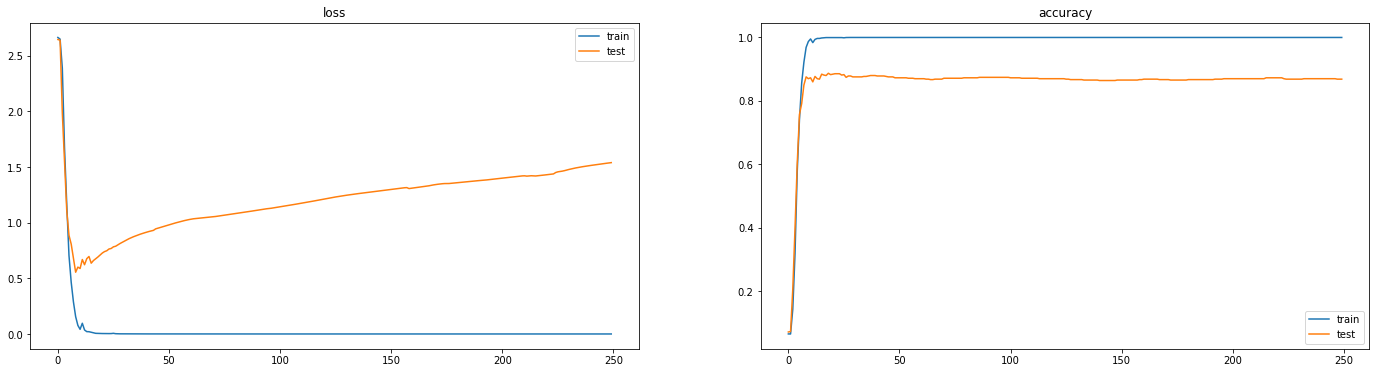

In [52]:
# Plot the entropy cost on the training data and 
# the accuracy on the testing data against training epochs.
plot_loss_accuracy_curves(num_epochs, history.history)

val_accuracies = history.history['val_accuracy']
print(f'highest validation accuracy achieved: {max(val_accuracies)}')